<a href="https://colab.research.google.com/github/seank934/project1/blob/main/project_1_envecon_153.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 

In [ ]:
!pip install wbdata
import wbdata
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas

In [ ]:
SOURCE = 40
indicators = wbdata.get_indicator(source = SOURCE)
#indicators

In [ ]:
wbdata.get_dataframe({"SP.POP.5559.MA":"Russia Population", "SP.POP.AG23.MA.IN": "hello"}, country="RUS")

## [#A] Population Statistics

In [ ]:
def round_first(age):
  k = age - age % 5
  return np.max([0, k])

def round_last(age):
  return age - age % 5 + 4


def population(year, sex, age_range, place):
  # find population dataframe for age range (currently assuming age_range values are multiple of 5; add interpolation in the future)
  variable_labels = []
  
  sex_postfix = "MA"
  if sex == "Female":
    sex_postfix = "FE"
  first = round_first(age_range[0])
  last = np.min([80, round_last(age_range[1])])
  for i in range(first, last, 5):
    variable_labels.append("SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + sex_postfix)
  
  # manually add 80UP 
  if age_range[1] >= 80:
    variable_labels.append("SP.POP.80UP." + sex_postfix)
    
  empty_dict = {}
  for i in variable_labels:
      empty_dict[i] = i
  pop = wbdata.get_dataframe(empty_dict, country=place)
  pop = pop.transpose()
  pop = pop[str(year)].sum()
  return pop

In [ ]:
population(year=1966,sex='Male',age_range=(18,26),place='RUS')

In [ ]:
# assert population(year=2000,sex='Male',age_range=(0,100),place='WLD') > 7e9
# This should be false because the male population should never be exceeding 7 billion in the year 2000 as that is the entire world population.

## [#A] Population DataFrames



In [ ]:
def new_pop(place):
  # find population dataframe for age range (currently assuming age_range values are multiple of 5; add interpolation in the future)
  variable_labels_male = {}
  variable_labels_female = {}
  
  for i in range(0, 80, 5):
    variable_labels_male["SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + 'MA'] = (i, i+4)
    variable_labels_female["SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + 'FE'] = (i, i+4)
  
  # manually add 80UP 
  variable_labels_male["SP.POP.80UP." + 'MA'] = ('80 and up')
  variable_labels_female["SP.POP.80UP." + 'FE'] = ('80 and up')

  pop_m = wbdata.get_dataframe(variable_labels_male, country=place)
  pop_m = pop_m.transpose()
  pop_m = pop_m.stack().reset_index(-1).iloc[:, ::-1]
  pop_m = pop_m.reset_index()
  pop_m = pop_m.rename(columns={0: 'male', "index": "age group"})

  pop_f = wbdata.get_dataframe(variable_labels_female, country=place)
  pop_f = pop_f.transpose()
  pop_f = pop_f.stack().reset_index(-1).iloc[:, ::-1]
  pop_f = pop_f.reset_index()
  pop_f = pop_f.rename(columns={0: 'female', "index": "age group"})

  pop =  pd.merge(pop_m, pop_f,  how='left', left_on=['age group','date'], right_on = ['age group','date'])

  pop = pop[["date", "age group", "male", "female"]]

  return pop

In [ ]:
new_pop(place='RUS')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



,date,age group,male,female
0,2020,"(0, 4)",4703088.0,4452313.0
1,2019,"(0, 4)",4781058.0,4524512.0
2,2018,"(0, 4)",4838806.0,4576591.0
3,2017,"(0, 4)",4868384.0,4602696.0
4,2016,"(0, 4)",4843381.0,4579788.0
...,...,...,...,...
1032,1964,80 and up,318272.0,923010.0
1033,1963,80 and up,310111.0,884717.0
1034,1962,80 and up,297620.0,841338.0
1035,1961,80 and up,282229.0,793681.0


## [#B] Population Pyramids

In [ ]:
def pop_pyramid(df):
  age_ranges = []
  # creating population pyramid in increments of 5 years
  for i in range(0,100,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

  age_ranges.append("80UP")

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 100], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'))

  # distinguishing between male and female (two sides of the pyramid)
  bins = [go.Bar(x = df['male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),

        go.Bar(x = -df['female'],
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
  py.iplot(dict(data=bins, layout=layout))

In [ ]:
pop_pyramid(new_pop(place='RUS'))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



## [#C] Animated Population Pyramids

In [ ]:
def pop_pyramid_ani(year):
  age_ranges = []
  df = new_pop(place='RUS')
  df = df[df['date'] == str(year)]
  # creating population pyramid in increments of 5 years
  for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

  age_ranges.append("80UP")

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'))

  # distinguishing between male and female (two sides of the pyramid)
  bins = [go.Bar(x = df['male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),

        go.Bar(x = -df['female'],
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
  py.iplot(dict(data=bins, layout=layout))

In [ ]:
years = new_pop(place='RUS')['date']
years.sort_values
max = years[0]
min = years.values[-1]

interact(pop_pyramid_ani, year=(int(min), int(max)))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



interactive(children=(IntSlider(value=1990, description='year', max=2020, min=1960), Output()), _dom_classes=(…

<function __main__.pop_pyramid_ani>

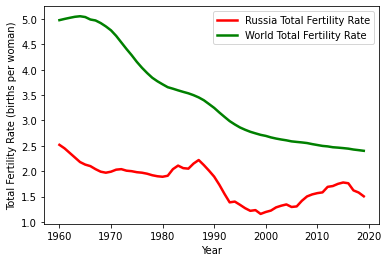

In [ ]:
# fertility rate visualization 
cf.go_offline()
wbdata.get_country('RUS')

variable_labels = {"SP.DYN.TFRT.IN":"Russia Total Fertility Rate"}

RUS_FR = wbdata.get_dataframe(variable_labels, country="RUS")
RUS_FR = RUS_FR.reset_index()
# By Russian fertility from 1960 - 2020
RUS_FR['date'] = RUS_FR['date'].astype(int)
# By World fertility from 1960 - 2020
variable_labels = {"SP.DYN.TFRT.IN":"World Total Fertility Rate"}
WLD_FR = wbdata.get_dataframe(variable_labels, country="WLD")
WLD_FR = WLD_FR.reset_index()
WLD_FR['date'] = WLD_FR['date'].astype(int)

fig, ax = plt.subplots()
sns.lineplot(data=RUS_FR, x="date", y="Russia Total Fertility Rate", 
             label = 'Russia Total Fertility Rate', color='red', linewidth=2.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=WLD_FR, x="date", y="World Total Fertility Rate", 
             label = 'World Total Fertility Rate', color='green', linewidth=2.5, ax = ax)

plt.xticks(np.arange(np.min(RUS_FR['date']), np.max(RUS_FR['date'])+1, 10))
ax.set(xlabel='Year', ylabel='Total Fertility Rate (births per woman)');

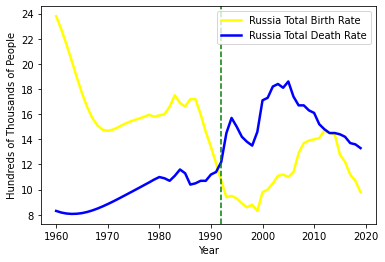

In [ ]:

# birth vs death rate
new_variable_label = {"SP.DYN.CBRT.IN":"Russia Total Birth Rate"}
# birth rate
RUS_BR = wbdata.get_dataframe(new_variable_label, country="RUS")
RUS_BR = RUS_BR.reset_index()

RUS_BR['date'] = RUS_BR['date'].astype(int)

next_variable_label = {"SP.DYN.CDRT.IN":"Russia Total Death Rate"}
# death rate
RUS_DR = wbdata.get_dataframe(next_variable_label, country="RUS")
RUS_DR = RUS_DR.reset_index()

RUS_DR['date'] = RUS_DR['date'].astype(int)

fig, ax = plt.subplots()
sns.lineplot(data=RUS_BR, x="date", y="Russia Total Birth Rate", 
             label = 'Russia Total Birth Rate', color='yellow', linewidth=2.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=RUS_DR, x="date", y="Russia Total Death Rate", 
             label = 'Russia Total Death Rate', color='blue', linewidth=2.5, dashes=(5, 1), ax = ax)

# line indicates intersection point
plt.axvline(x = 1992, color = 'green', linestyle = '--')

plt.xticks(np.arange(np.min(RUS_BR['date']), np.max(RUS_BR['date'])+1, 10))
ax.set(xlabel='Year', ylabel='Hundreds of Thousands of People');

## Part C: Population Maps

In [ ]:
!pip install geopandas

In [ ]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.colab import files

Upload this file to the cell below https://docs.google.com/spreadsheets/d/1MixyKBAuL6rescUaKW-CQcmVx9foA5QTW072iJnuBgQ/edit?usp=sharing

In [ ]:
uploaded = files.upload()
rus_pop = pd.read_csv(io.BytesIO(uploaded['rus_pop.csv']))

In [ ]:
map2_geojson = files.upload()
map2 = geopandas.read_file(io.BytesIO(map2_geojson['custom.geo.json']))

In [ ]:
world_pop_file = files.upload()
world_pop = pd.read_csv(io.BytesIO(world_pop_file['worldpop.csv']))

merged2 = map2.merge(world_pop, how='left', left_on="admin", right_on="name")

In [ ]:
url = "https://raw.githubusercontent.com/Kreozot/russian-geo-data/master/geo.json"
rus_map = geopandas.read_file(url)
merged = rus_map.merge(rus_pop, how='left', left_on="NAME_1", right_on="Federal subject")

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
0,186,RUS,Russia,28,Karachay-Cherkess,?????????-????????? ??????????,Karaçay-Çerkes|Karachay-Cherkessiya|Karachayev...,Respublika,Republic,"POLYGON ((42.13194 44.34488, 42.19061 44.32248..."
1,186,RUS,Russia,29,Karelia,?????????? ???????,Karelian A.S.S.R.|Karelo-Finnish A.S.S.R.|Kare...,Respublika,Republic,"MULTIPOLYGON (((36.77098 64.02402, 36.75969 64..."
2,186,RUS,Russia,30,Kemerovo,??????????? ???????,Kemerovskaya Oblast,Oblast,Region,"POLYGON ((88.63731 56.77809, 88.64615 56.73922..."
3,186,RUS,Russia,31,Khabarovsk,??????????? ????,Khabarovskiy Kray,Kray,Territory,"MULTIPOLYGON (((136.64362 45.04694, 136.64417 ..."
4,186,RUS,Russia,32,Khakass,?????????? ???????,Khakassiya|Republic of Khakasia|Khakasskaya A....,Respublika,Republic,"MULTIPOLYGON (((91.45279 53.70172, 91.44386 53..."
...,...,...,...,...,...,...,...,...,...,...
80,186,RUS,Russia,40,Krasnoyarsk,???????????? ????,Krasnoyarskiy Kray|Yeniseisk|Yeniseyskaya G.,Kray,Territory,"MULTIPOLYGON (((106.36668 69.53505, 106.28728 ..."
81,186,RUS,Russia,21,Irkutsk,????????? ???????,Irkutskaya Oblast,Oblast,Region,"POLYGON ((108.51489 64.24889, 108.49897 64.208..."
82,186,RUS,Russia,13,Zabaikalskiy Krai,None,Zabaikalskiy Krai,Oblast,Region,"MULTIPOLYGON (((107.70453 49.95612, 107.69301 ..."
83,186,RUS,Russia,27,Kamchatka,?????????? ???????,Kamï¿½atka|Kamchatskaya Oblast,Oblast,Region,"MULTIPOLYGON (((157.27618 51.24185, 157.27545 ..."


(0.0, 200.0)

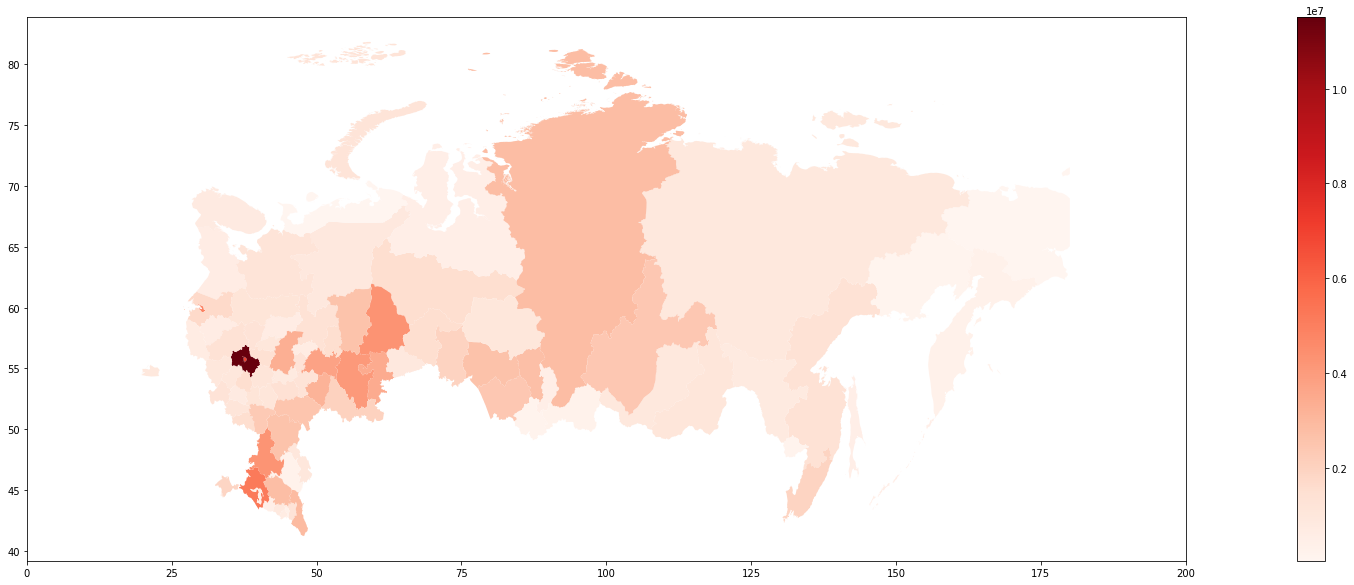

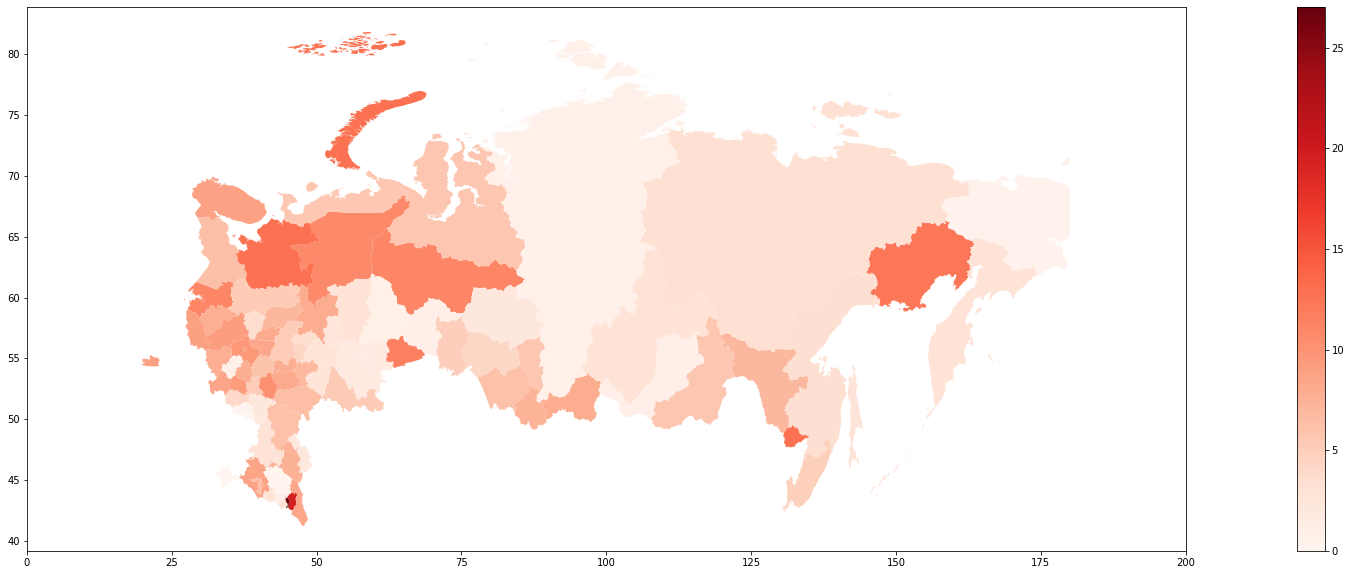

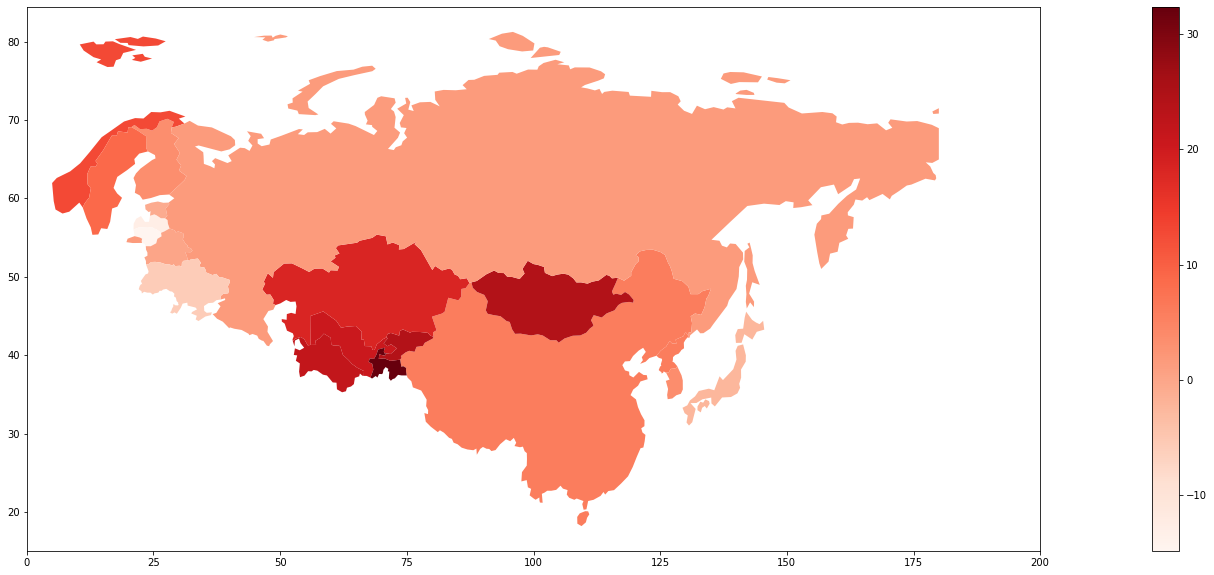

In [ ]:
# plot populations of provinces in Russia in 2010
merged.plot("Population 2010", legend=True, figsize=(40,10), cmap="Reds")
plt.xlim([0,200])

In [ ]:
# plot % change in population from 2010 to 2022 of provinces in Russia
merged.plot("% change", figsize=(40,10), legend=True, cmap="Reds")
plt.xlim([0,200])

In [ ]:
# plot % change in population from 2010 to 2022 of Russia and surrounding countries
merged2.plot("growth %", legend=True, figsize=(40,10), cmap="Reds")
plt.xlim([0,200])

In [ ]:
wbdata.get_topic()   

  id  value
----  -------------------------------
   1  Agriculture & Rural Development
   2  Aid Effectiveness
   3  Economy & Growth
   4  Education
   5  Energy & Mining
   6  Environment
   7  Financial Sector
   8  Health
   9  Infrastructure
  10  Social Protection & Labor
  11  Poverty
  12  Private Sector
  13  Public Sector
  14  Science & Technology
  15  Social Development
  16  Urban Development
  17  Gender
  18  Millenium development goals
  19  Climate Change
  20  External Debt
  21  Trade

In [ ]:
from wbdata.api import get_topic
wbdata.get_indicator(topic=1, cache=True)

In [ ]:
wbdata.get_dataframe({"AG.PRD.CREL.MT":"Cereal Production in Russia"}, country="RUS")

In [ ]:
# Creating Line plot for Cereal Production
wbdata.get_dataframe({"AG.PRD.CREL.MT":"Cereal Production in Russia"}, country="RUS")
df = wbdata.get_dataframe({"AG.PRD.CREL.MT":"Cereal Production in Russia"}, country="RUS")
df.plot().invert_xaxis();

In [ ]:
wbdata.get_dataframe({"SP.RUR.TOTL.ZG":"Russia's Rural Population Growth Rate"},country="RUS")

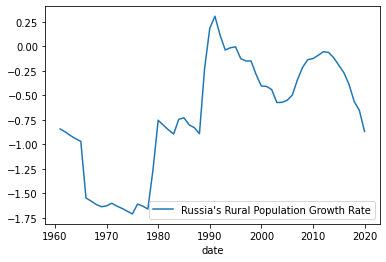

In [ ]:
# Creating Line Plot for Rural Population Growth Rate
wbdata.get_dataframe({"SP.RUR.TOTL.ZG":"Russia's Rural Population Growth Rate"},country="RUS")
df2 = wbdata.get_dataframe({"SP.RUR.TOTL.ZG":"Russia's Rural Population Growth Rate"},country="RUS")
df2.plot().invert_xaxis();